Wildfire Project Part 1

Kyle Sorstokke

In [37]:
import os, json, time
from pyproj import Transformer, Geod
from wildfire.wildfire.Reader import Reader as WFReader
import geojson
from datetime import datetime
import matplotlib.pyplot as plt
import dateutil.parser as dparser
import requests

In [2]:
# Constants

EXTRACT_FILENAME = r'GeoJSON Files\GeoJSON Exports\USGS_Wildland_Fire_Combined_Dataset.json'

wfreader = WFReader(EXTRACT_FILENAME)

header_dict = wfreader.header()
header_keys = list(header_dict.keys())

feature_list = list()
feature = wfreader.next()

while feature:
    feature_list.append(feature)
    feature = wfreader.next()


In [3]:
# Filter for only modern fires
modern_fires = list()
for feat in feature_list:
    if feat['attributes']['Fire_Year'] >= 1961:
        modern_fires.append(feat)

In [4]:
geodcalc = Geod(ellps='WGS84')         # Use WGS84 ellipsoid representation of the earth


In [5]:
#
#    Transform feature geometry data
#
#    The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
#    The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

In [6]:
#    
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns a list containing the shortest distance to the perimeter and the point where that is
#
def shortest_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    closest_point = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        # convert the distance to miles
        distance_in_miles = d[2]*0.00062137
        # if it's closer to the city than the point we have, save it
        if not closest_point:
            closest_point.append(distance_in_miles)
            closest_point.append(point)
        elif closest_point and closest_point[0]>distance_in_miles:
            closest_point = list()
            closest_point.append(distance_in_miles)
            closest_point.append(point)
    return closest_point


In [7]:
alb_loc = [35.1, -106.65]

for wf_feature in modern_fires:
    try:
        if 'rings' in wf_feature['geometry']:
            ring_data = wf_feature['geometry']['rings'][0]
        elif 'curveRings' in wf_feature['geometry']:
            ring_data = wf_feature['geometry']['curveRings'][0]
        else:
            continue
        distance = shortest_distance_from_place_to_fire_perimeter(alb_loc,ring_data)
        wf_feature['albuquerque_distance'] = distance[0]
    except:
        continue


In [8]:
i = 100
for fire in modern_fires:
    if i>100:
        break
    print(fire['attributes'].keys())
    i = i + 1

dict_keys(['OBJECTID', 'USGS_Assigned_ID', 'Assigned_Fire_Type', 'Fire_Year', 'Fire_Polygon_Tier', 'Fire_Attribute_Tiers', 'GIS_Acres', 'GIS_Hectares', 'Source_Datasets', 'Listed_Fire_Types', 'Listed_Fire_Names', 'Listed_Fire_Codes', 'Listed_Fire_IDs', 'Listed_Fire_IRWIN_IDs', 'Listed_Fire_Dates', 'Listed_Fire_Causes', 'Listed_Fire_Cause_Class', 'Listed_Rx_Reported_Acres', 'Listed_Map_Digitize_Methods', 'Listed_Notes', 'Processing_Notes', 'Wildfire_Notice', 'Prescribed_Burn_Notice', 'Wildfire_and_Rx_Flag', 'Overlap_Within_1_or_2_Flag', 'Circleness_Scale', 'Circle_Flag', 'Exclude_From_Summary_Rasters', 'Shape_Length', 'Shape_Area'])


In [9]:
# Filter for fire season only
season_fires = list()

for fire in modern_fires:
    try:
        date_string = fire['attributes']['Listed_Fire_Dates']
        year_str = str(fire['attributes']['Fire_Year'])
        date_ind = date_string.find(year_str)
        fire_date = datetime.strptime(date_string[date_ind:(date_ind+10)], "%Y-%m-%d")
        fire_month = fire_date.month
        if fire_month >= 5 & fire_month <= 10:
            season_fires.append(fire)
    except:
        continue

## Plot 1: Distance Histogram

In [30]:
all_dist = list()
for fire in season_fires:
    try:
        dist = fire['albuquerque_distance']
        if dist <= 1800:
            all_dist.append(dist)
    except:
        continue

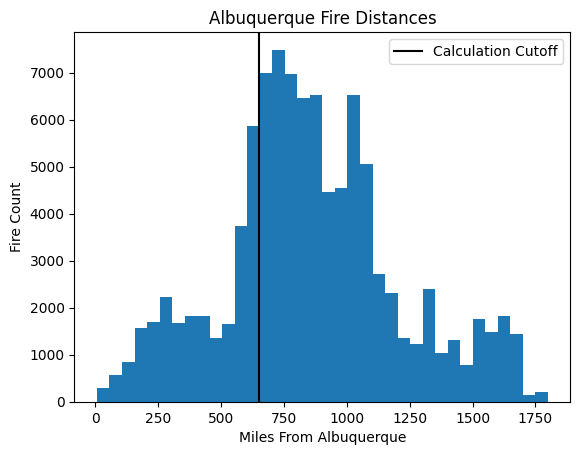

In [32]:
# Define and create the histogram of fire distances from Albuquerque (under 1800 miles)
plt.hist(all_dist, bins=36)
plt.axvline(x = 650, color = 'black', label = 'Calculation Cutoff')
plt.xlabel("Miles From Albuquerque")
plt.ylabel("Fire Count")
plt.title("Albuquerque Fire Distances")
plt.legend();

## Plot 2: Total Acres within 650 Miles

In [33]:
acres_by_year = {}
for fire in season_fires:
    try:
        y = fire['attributes']['Fire_Year']
        if not (y in acres_by_year.keys()):
            acres_by_year[y] = 0
        dist = fire['albuquerque_distance']
        size = fire['attributes']['GIS_Acres']
        if dist <= 650:
            acres_by_year[y] = acres_by_year[y] + size
    except:
        continue

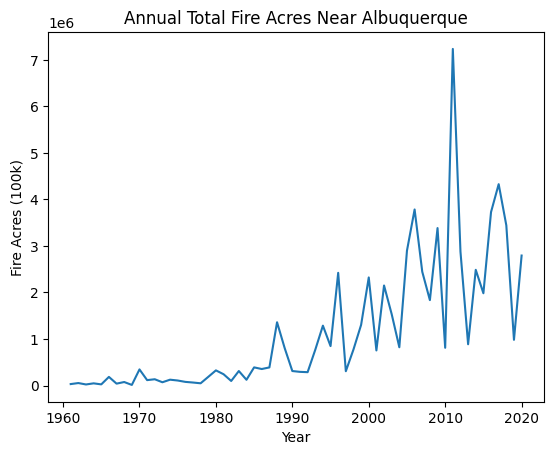

In [35]:
years = sorted(acres_by_year.keys())
total_acres = list()
for year in years:
    total_acres.append(acres_by_year[year])
plt.plot(years, total_acres)
plt.title("Annual Total Fire Acres Near Albuquerque")
plt.xlabel("Year")
plt.ylabel("Fire Acres (100k)");

## Estimates

For the smoke estimate, I will use the ratio fire size divided by distance from city. For the AQI estimate, I will use cumulative measurements of each day contained within the fire season (to match annual totals against my cumulative fire impact metric).

In [ ]:
# Calculate the total fire strength for each year using my derived metric
strength_by_year = {}
for fire in season_fires:
    try:
        y = fire['attributes']['Fire_Year']
        if not (y in strength_by_year.keys()):
            strength_by_year[y] = 0
        dist = fire['albuquerque_distance']
        size = fire['attributes']['GIS_Acres']
        if dist <= 650:
            fire_strength = size / dist
            strength_by_year[y] = strength_by_year[y] + fire_strength
    except:
        continue

In [ ]:
# AQI API setup

API_REQUEST_URL = 'https://aqs.epa.gov/data/api'


API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

API_ACTION_SIGNUP = '/signup?email={email}'

API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'

API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'

API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'

API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}


# Function to request signup permissions for AQI API calls
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL, 
                   endpoint_action = API_ACTION_SIGNUP, 
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):
    
    if email_address:
        request_template['email'] = email_address        
    
    if not request_template['email']: 
        raise Exception("Must supply an email address to call 'request_signup()'")

    if '@' not in request_template['email']: 
        raise Exception(f"Must supply an email address to call 'request_signup()'. The string '{request_template['email']}' does not look like an email address.")

    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    try:
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


In [ ]:
# Signup request

# print("Requesting SIGNUP ...")
# USERNAME = "kjs88@uw.edu"
# response = request_signup(USERNAME)
# print(json.dumps(response,indent=4))

In [ ]:
# Define Username and API key for AQI calls
USERNAME = "kjs88@uw.edu"
APIKEY = "sandcrane15"

In [ ]:
# Function to request list info
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    try:
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response




In [ ]:
# Request data field setup
AQI_PARAM_CLASS = "AQI POLLUTANTS"

request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS

In [ ]:
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
AQI_PARAMS_PARTICULATES = "81102,88101,88502"

# County code that covers Albuquerque
alb_fips = '35001'

request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = alb_fips[:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = alb_fips[2:]  # the last three digits (characters) of FIPS is the county code

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)


In [ ]:
# Target fields for AQI extractions
EXTRACTION_FIELDS = ['sample_duration','observation_count','arithmetic_mean','aqi']

# Summarize the useful information from API response
def extract_summary_from_response(r=None, fields=EXTRACTION_FIELDS):
    result = dict()
    data = r["Data"]
    for record in data:
        site = record['site_number']
        param = record['parameter_code']
        date = record['date_local']    # this version keeps the respnse value YYYY-MM-DD
        if site not in result:
            result[site] = dict()
            result[site]['local_site_name'] = record['local_site_name']
            result[site]['site_address'] = record['site_address']
            result[site]['state'] = record['state']
            result[site]['county'] = record['county']
            result[site]['city'] = record['city']
            result[site]['pollutant_type'] = dict()
        if param not in result[site]['pollutant_type']:
            result[site]['pollutant_type'][param] = dict()
            result[site]['pollutant_type'][param]['parameter_name'] = record['parameter']
            result[site]['pollutant_type'][param]['units_of_measure'] = record['units_of_measure']
            result[site]['pollutant_type'][param]['method'] = record['method']
            result[site]['pollutant_type'][param]['data'] = dict()
        if date not in result[site]['pollutant_type'][param]['data']:
            result[site]['pollutant_type'][param]['data'][date] = list()
        
        # now extract the specified fields
        extract = dict()
        for k in fields:
            if str(k) in record:
                extract[str(k)] = record[k]
            else:
                extract[str(k)] = None
        
        # add this extraction to the list for the day
        result[site]['pollutant_type'][param]['data'][date].append(extract)
    
    return result


In [ ]:
# Define function for API request of daily AQI summary information

def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



In [ ]:
request_data_gaseous = request_data.copy()
request_data_particulate = request_data.copy()

request_data_gaseous['param'] = AQI_PARAMS_GASEOUS
request_data_particulate['param'] = AQI_PARAMS_PARTICULATES


years = range(1961,2021)

annual_aqi = {}
for year in years:
    year_aqi = 0
    bdate = str(year) + "0501"
    edate = str(year) + "1031"
    gaseous_aqi = request_daily_summary(request_template=request_data_gaseous, begin_date=bdate, end_date=edate)
    particulate_aqi = request_daily_summary(request_template=request_data_particulate, begin_date=bdate, end_date=edate)
    extract_gaseous = extract_summary_from_response(gaseous_aqi)
    gas_stations = extract_gaseous.keys()
    extract_particulate = extract_summary_from_response(particulate_aqi)
    part_stations = extract_particulate.keys()
    for station in list(gas_stations):
        s = extract_gaseous[station]
        for p in s['pollutant_type']:
            pol = s['pollutant_type'][p]['data']
            for d in pol:
                for sample in pol[d]:
                    for obs in sample:
                        if obs=="arithmetic_mean":
                            year_aqi = year_aqi + sample[obs]
    for station in list(part_stations):
        s = extract_particulate[station]
        for p in s['pollutant_type']:
            pol = s['pollutant_type'][p]['data']
            for d in pol:
                for sample in pol[d]:
                    for obs in sample:
                        if obs=="arithmetic_mean":
                            year_aqi = year_aqi + sample[obs]
    annual_aqi[year] = year_aqi


In [91]:
chrono_aqi = list()
years = sorted(strength_by_year.keys())
for year in years:
    chrono_aqi.append(annual_aqi[year]/10)

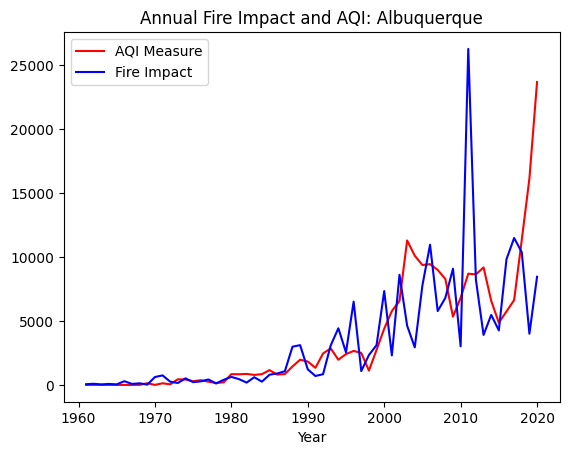

In [92]:
# Get chronological strengths and AQIs, then plot timeseries
strengths = list()
for year in years:
    strengths.append(strength_by_year[year])
plt.plot(years,chrono_aqi,color='red', label = "AQI Measure")
plt.plot(years,strengths,color='blue', label = "Fire Impact")
plt.title("Annual Fire Impact and AQI: Albuquerque")
plt.xlabel("Year")
plt.legend();

## Fire Prediction

In [129]:
def pred_year(target_year):
    weights = [x/100 for x in range(45,55)]
    comp_years = list(range(target_year-11, target_year))
    comp_vals = list()
    for y in range(0,10):
        comp_vals.append(strength_by_year[comp_years[y]])
    pred_val = 0
    for i in range(0,10):
        pred_val = pred_val + (comp_vals[i]*weights[i])
    pred_val = pred_val/sum(weights)
    return pred_val

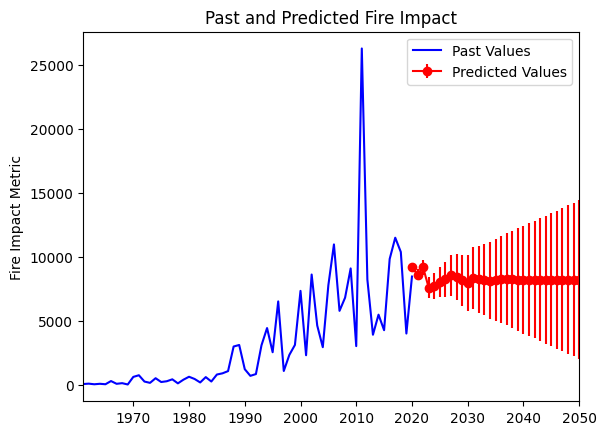

In [135]:
years = list(range(1961,2021))
orig_years = years.copy()
pred_years = list(range(years[-1],2051))
error_fac = list()
for i in range(1,32):
    error_fac.append(i*200)
years = years + pred_years
pred_fires = list()
for y in pred_years:
    pred_val = pred_year(y)
    strength_by_year[y] = pred_val
    pred_fires.append(pred_val)
plt.xlim(1961,2050)
plt.plot(orig_years,strengths,color='blue', label = "Past Values")
plt.errorbar(pred_years, pred_fires, yerr=error_fac, color = "red", fmt='-o', label="Predicted Values")
plt.title("Past and Predicted Fire Impact")
plt.ylabel("Fire Impact Metric")
plt.xlabel=("Year")
plt.legend();


In [133]:
with open('fire_strength_by_year.json', 'w') as file:
    json.dump(strength_by_year, file)

with open('annual_aqi.json', 'w') as file:
    json.dump(annual_aqi, file)



In [134]:
pred_dict = {}
for i in range(0,len(pred_years)):
    pred_dict[pred_years[i]] = pred_fires[i]

with open('predicted_fire_impact.json', 'w') as file:
    json.dump(pred_dict, file)


## Write and Reflect

* Visualization 1

Figure 1 is a histogram that represents distance on the x-axis and fire count on the y-axis. It shows how many fires occurred in each 50 mile bucket of distance away from Albuquerque since 1961, with 50 mile bucket sizes.

* Visualization 2

Figure 2 shows the total acreage of fires within 650 miles of Albuquerque for each year in recent history. Filtered to only include fires within this radius, the dataset adds the total acres for each fire per year to create an annual total fire size value. This metric is on the y-axis, with year on the x-axis.

* Visualization 3

Figure 3 shows the trends since 1961 in my calculated metrics for fire impact and AQI. The red line is AQI, with the blue line representing fire impact. While these calculated fields have largely lost physical meaning in the literal units, they are still useful measurements of the magnitude of fire and pollution each year.

* Visualization 4

The final plot, while not one of the three requested in the instructions, is the predictions for my future fire impact measurements. Because the fires seem to be largely random year-to-year with a potential small increase over time, the predictions stabilize fairly quickly; this is due to the methodology of using weighted averages of past years, since there is more noise than trend in annual fire fluctuations in this region.

Notes/Process

* Using cumulative fire season: unreliable data for specific fire days, capturing annual trends
* Given that my metrics are composed of many different measurement types, they essentially represent an abstract magnitude of fire impact or pollutants, with units that do not translate back to the original statistics. As such, I apply linear transformations for data visualization, without impacting the interpretability of my metrics.
* Given that my impact metric inherently scales by distance from Albuquerque, I included every fire within the 650 mile range instead of narrowing down the region

From answering the research question posed here, I learned how complicated it can be to work with historical data that was collected largely before standardization and cleaning became common practice. While there was sufficient data available, many of the older points were missing variables or less reliably collected and stored. This creates a challenge in data reading and wrangling that I am not used to, having primarily worked with well standardized modern datasets. Collaboration was useful here because different people notice different issues with the dataset, so they can point something out before it becomes a problem discovered by each individual on their own. While I did not collaborate on or reuse any actual code (other than the samples provided by Dr. McDonald), I was helped by explanations into data schema and underlying factors to extract or handle with certain considerations in mind.